# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Parameters

In [2]:
nx = 51 # number of continuity/scalar/pressure control volumes in x-direction
ny = 51 # number of continuity/scalar/pressure control volumes in y-direction

x_min, x_max = 0., 1.
y_min, y_max = 0., 1.

dx = (x_max-x_min)/nx
dy = (y_max-y_min)/ny

# Set fluid properties
μ = 0.01
ρ = 1.0

# number of outer iterations
outer_iterations = 1000

# set relaxation factors
ω_u = 0.7 # x-momentum under-relaxation
ω_v = 0.7 # y-momentum under-relaxation
ω_p = 0.3 # x-momentum under-relaxation

# SOR over-relaxation factor
Ω = 1.7

# set top wall veclocity
u_wall = 1.0

# Initialize Arrays

Initialize variables for driven cavity,<br>
$u=0$, $v=0$, $p=0$ and set top wall boundary condition $u_{\text{wall}}=1.0$.

In [3]:
u = np.zeros([ny+2,nx+2])
v = np.zeros([ny+2,nx+2])
p = np.zeros([ny+2,nx+2])
u_old = np.zeros([ny+2,nx+2])
v_old = np.zeros([ny+2,nx+2])
p_corr = np.zeros([ny+2,nx+2])

Apu = np.ones([ny+2,nx+2])
Apv = np.ones([ny+2,nx+2])
App = np.ones([ny+2,nx+2])

Ae = np.ones([ny+2,nx+2])
Aw = np.ones([ny+2,nx+2])
An = np.ones([ny+2,nx+2])
As = np.ones([ny+2,nx+2])

source = np.zeros([ny+2,nx+2])

u_nodal = np.zeros([ny+2,nx+2])
v_nodal = np.zeros([ny+2,nx+2])
p_nodal = np.zeros([ny+2,nx+2])
x_nodal = np.zeros([ny+2,nx+2])
y_nodal = np.zeros([ny+2,nx+2])
Vel_mag = np.zeros([ny+2,nx+2])

**Set top wall boundary condition for driven cavity**

In [4]:
u[ny+1,:] = u_wall   # j = ny+1/-1, i = everything

Initialize $\mathbf{u_{\text{old}}}$, $\mathbf{v_{\text{old}}}$

In [5]:
u_old[:,:] = u[:,:]
v_old[:,:] = v[:,:]

**Begin outer iteration loop for sequential solution procedure**

In [6]:
for outeriteration in range(1,outer_iterations+1):
    # X-momentum equation solution
    # set x-momentum coefficients
    for j in range(1,ny+1):
        for i in range(2,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j,i]),0.) + μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i-1]+u_old[j,i]),0.) + μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j+1,i]+v_old[j+1,i-1]),0.) + μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j,i-1]),0.) + μ*dx/dy
            
    # overwrite boundary coefficients along north/south walls with half cells (dy/2) size
    for i in range(2,nx+1):
        An[ny,i] = max(-0.5*ρ*dx*(v_old[ny+1,i]+v_old[ny+1,i-1]),0.) + μ*dx/(dy/2)
        As[1,i] = max( 0.5*ρ*dx*(v_old[1,i]+v_old[1,i-1]),0.) + μ*dx/(dy/2)
        
    Apu[:,:] = Ae[:,:] + Aw[:,:] + An[:,:] + As[:,:]
    # Under-relaxation
    Apu[:,:] = Apu[:,:]/ω_u
    
    # Iterate x-momentum equations
    for _ in range(1,10+1):
        for j in range(1,ny+1):
            for i in range(2,nx+1):
                u[j,i] = (1.-ω_u)*u_old[j,i] + (1./Apu[j,i])*(Ae[j,i]*u[j,i+1]+Aw[j,i]*u[j,i-1]+An[j,i]*u[j+1,i]\
                                                                       + As[j,i]*u[j-1,i]+dy*(p[j,i-1]-p[j,i]))
    # Solve y-momentum equation
    for j in range(2,ny+1):
        for i in range(1,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j-1,i+1]),0.) + μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i]+u_old[j-1,i]),0.) + μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j,i]+v_old[j+1,i]),0.) + μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j-1,i]),0.) + μ*dx/dy
            
    # overwrite boundary coefficients along east/west cells due to half cell (dx) size
    for j in range(2,ny+1):
        Ae[j,nx] = max(-0.5*ρ*dy*(u_old[j,nx+1]+u_old[j-1,nx+1]),0.) + μ*dy/(dx/2.)
        Aw[j,1] = max( 0.5*ρ*dy*(u_old[j,1]+u_old[j-1,1]),0.) + μ*dy/(dx/2.)
        
    Apv[:,:] = Ae[:,:] + Aw[:,:] + An[:,:] + As[:,:]
    # Under-relaxation
    Apv[:,:] = Apv[:,:]/ω_v
    
    # Iterate y-momentum equations
    for _ in range(1,10+1):
        for j in range(2,ny+1):
            for i in range(1,nx+1):
                v[j,i] = (1.-ω_v)*v_old[j,i] + (1./Apv[j,i])*(Ae[j,i]*v[j,i+1]+Aw[j,i]*v[j,i-1]+An[j,i]*v[j+1,i]\
                                                                       + As[j,i]*v[j-1,i]+dx*(p[j-1,i]-p[j,i]))
                
    # Pressure correction equation
    # set coefficients
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            Ae[j,i] = ρ*dy**2./Apu[j,i+1]
            Aw[j,i] = ρ*dy**2./Apu[j,i]
            An[j,i] = ρ*dx**2./Apv[j+1,i]
            As[j,i] = ρ*dx**2./Apv[j,i]
            
    # set boundary values for correction
    Ae[:,nx] = 0.0
    Aw[:,1] = 0.0
    An[ny,:] = 0.0
    As[1,:] = 0.0
    
    App[:,:] = Ae[:,:] + Aw[:,:] + An[:,:] + As[:,:]
    App[1,1] = 1.e30 # set reference cell valuw for pressure
    p_corr[:,:] = 0.0 # initialize corrections to zero
    
    source[:,:] = 0.0
    # compute the mass-source term
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
            
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {outeriteration}, mass residue = {mass_residue}')
    
    # SOR iterations to solve for pressure correction, p_corr
    for _ in range(1,101):
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                p_corr[j,i] = p_corr[j,i] + Ω/App[j,i]*(Ae[j,i]*p_corr[j,i+1]+Aw[j,i]*p_corr[j,i-1]+An[j,i]*p_corr[j+1,i]\
                                                       +As[j,i]*p_corr[j-1,i]-source[j,i]-App[j,i]*p_corr[j,i])
                
    # Apply corrections to pressure
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            p[j,i] = p[j,i] + ω_p*p_corr[j,i]
            
    # Apply corrections to u-velocity
    for j in range(1,ny+1):
        for i in range(2,nx+1):
            u[j,i] = u[j,i] + (dy/Apu[j,i])*(p_corr[j,i-1]-p_corr[j,i])
            
    # Apply corrections to u-velocity
    for j in range(2,ny+1):
        for i in range(1,nx+1):
            v[j,i] = v[j,i] + (dx/Apv[j,i])*(p_corr[j-1,i]-p_corr[j,i])
            
    # Update velocity variables
    u_old[:,:] = u[:,:]
    v_old[:,:] = v[:,:]
    
    # Check - u_old and v_old are now mass conserving
    # recompute source term to verify that mass is being conserved after corrections
    source[:,:] = 0.0
    # compute the mass-source term
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
            
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {outeriteration}, mass residue = {mass_residue}')
    print()
    
    # End of outer iteration

outer iteration = 1, mass residue = 0.01009323512579361
outer iteration = 1, mass residue = 0.00029092837491653594

outer iteration = 2, mass residue = 0.005670758083179172
outer iteration = 2, mass residue = 0.0006699146494466906

outer iteration = 3, mass residue = 0.003788538943854897
outer iteration = 3, mass residue = 0.000999666562906659

outer iteration = 4, mass residue = 0.0027163075029012556
outer iteration = 4, mass residue = 0.0007613862410998949

outer iteration = 5, mass residue = 0.0019242963818435995
outer iteration = 5, mass residue = 0.00040279385606749064

outer iteration = 6, mass residue = 0.0013387765761179165
outer iteration = 6, mass residue = 0.00018366751170254586

outer iteration = 7, mass residue = 0.0009418489923682764
outer iteration = 7, mass residue = 9.4962427433173e-05

outer iteration = 8, mass residue = 0.0006755529298369745
outer iteration = 8, mass residue = 5.916207370230228e-05

outer iteration = 9, mass residue = 0.0004930620254131096
outer iter

outer iteration = 70, mass residue = 2.5085382399771676e-05

outer iteration = 71, mass residue = 2.6688656570167672e-05
outer iteration = 71, mass residue = 2.462048851349458e-05

outer iteration = 72, mass residue = 2.618271980814684e-05
outer iteration = 72, mass residue = 2.4170530828638594e-05

outer iteration = 73, mass residue = 2.5700285241234456e-05
outer iteration = 73, mass residue = 2.373495108418197e-05

outer iteration = 74, mass residue = 2.5235757520404885e-05
outer iteration = 74, mass residue = 2.3313183103536594e-05

outer iteration = 75, mass residue = 2.4781809412019477e-05
outer iteration = 75, mass residue = 2.2904787307964496e-05

outer iteration = 76, mass residue = 2.4340595384492258e-05
outer iteration = 76, mass residue = 2.250937027117746e-05

outer iteration = 77, mass residue = 2.3915834196655448e-05
outer iteration = 77, mass residue = 2.2126524885316324e-05

outer iteration = 78, mass residue = 2.349898726254481e-05
outer iteration = 78, mass residue = 

outer iteration = 138, mass residue = 1.0779024709074327e-05

outer iteration = 139, mass residue = 1.1089837511798243e-05
outer iteration = 139, mass residue = 1.068207757836858e-05

outer iteration = 140, mass residue = 1.0988281619834932e-05
outer iteration = 140, mass residue = 1.0586282992956153e-05

outer iteration = 141, mass residue = 1.0885554019397289e-05
outer iteration = 141, mass residue = 1.0491596752909163e-05

outer iteration = 142, mass residue = 1.0783946347917668e-05
outer iteration = 142, mass residue = 1.039799540175611e-05

outer iteration = 143, mass residue = 1.0685171645119366e-05
outer iteration = 143, mass residue = 1.0305446499763392e-05

outer iteration = 144, mass residue = 1.0588149011367159e-05
outer iteration = 144, mass residue = 1.0213909044507873e-05

outer iteration = 145, mass residue = 1.049255080452974e-05
outer iteration = 145, mass residue = 1.0123365696310437e-05

outer iteration = 146, mass residue = 1.0398148581760998e-05
outer iteration = 1

outer iteration = 206, mass residue = 5.880636875633814e-06

outer iteration = 207, mass residue = 5.996897725110194e-06
outer iteration = 207, mass residue = 5.826655292366199e-06

outer iteration = 208, mass residue = 5.941770543815776e-06
outer iteration = 208, mass residue = 5.773078083923288e-06

outer iteration = 209, mass residue = 5.8870278782380716e-06
outer iteration = 209, mass residue = 5.719902637897e-06

outer iteration = 210, mass residue = 5.8326575828387944e-06
outer iteration = 210, mass residue = 5.667128350495984e-06

outer iteration = 211, mass residue = 5.778686314764493e-06
outer iteration = 211, mass residue = 5.6147554968739105e-06

outer iteration = 212, mass residue = 5.7246330166377384e-06
outer iteration = 212, mass residue = 5.5627815121278835e-06

outer iteration = 213, mass residue = 5.670904641934831e-06
outer iteration = 213, mass residue = 5.5112119171891465e-06

outer iteration = 214, mass residue = 5.617706033765797e-06
outer iteration = 214, mass r

outer iteration = 274, mass residue = 3.031996137179986e-06

outer iteration = 275, mass residue = 3.086602853205511e-06
outer iteration = 275, mass residue = 3.0010413235938605e-06

outer iteration = 276, mass residue = 3.0550694749709833e-06
outer iteration = 276, mass residue = 2.9703619284835037e-06

outer iteration = 277, mass residue = 3.02382651660386e-06
outer iteration = 277, mass residue = 2.939957026036111e-06

outer iteration = 278, mass residue = 2.9927931378873474e-06
outer iteration = 278, mass residue = 2.9098247862839957e-06

outer iteration = 279, mass residue = 2.9620919343736514e-06
outer iteration = 279, mass residue = 2.8799646091222576e-06

outer iteration = 280, mass residue = 2.9316882824293723e-06
outer iteration = 280, mass residue = 2.8503740986320434e-06

outer iteration = 281, mass residue = 2.9015657063185447e-06
outer iteration = 281, mass residue = 2.8210502256596046e-06

outer iteration = 282, mass residue = 2.871715440096429e-06
outer iteration = 282,

outer iteration = 341, mass residue = 1.4854315069069547e-06

outer iteration = 342, mass residue = 1.512128502945716e-06
outer iteration = 342, mass residue = 1.4691979721987862e-06

outer iteration = 343, mass residue = 1.4956165965300654e-06
outer iteration = 343, mass residue = 1.4531301205779713e-06

outer iteration = 344, mass residue = 1.4792728778062211e-06
outer iteration = 344, mass residue = 1.4372262976279824e-06

outer iteration = 345, mass residue = 1.4630339957077108e-06
outer iteration = 345, mass residue = 1.42148539059581e-06

outer iteration = 346, mass residue = 1.446951197740646e-06
outer iteration = 346, mass residue = 1.4059064324158983e-06

outer iteration = 347, mass residue = 1.4310836099685918e-06
outer iteration = 347, mass residue = 1.3904874935177973e-06

outer iteration = 348, mass residue = 1.415402031228517e-06
outer iteration = 348, mass residue = 1.3752267105233189e-06

outer iteration = 349, mass residue = 1.3998905757065226e-06
outer iteration = 349

outer iteration = 409, mass residue = 6.932766736850959e-07

outer iteration = 410, mass residue = 7.056190160885178e-07
outer iteration = 410, mass residue = 6.854333128410187e-07

outer iteration = 411, mass residue = 6.976365077203966e-07
outer iteration = 411, mass residue = 6.77676142610127e-07

outer iteration = 412, mass residue = 6.897416913582678e-07
outer iteration = 412, mass residue = 6.700042870419709e-07

outer iteration = 413, mass residue = 6.819336731307264e-07
outer iteration = 413, mass residue = 6.624168753066785e-07

outer iteration = 414, mass residue = 6.742115695590736e-07
outer iteration = 414, mass residue = 6.549130422370212e-07

outer iteration = 415, mass residue = 6.66574504814847e-07
outer iteration = 415, mass residue = 6.474919288163609e-07

outer iteration = 416, mass residue = 6.590216095543679e-07
outer iteration = 416, mass residue = 6.401526824723476e-07

outer iteration = 417, mass residue = 6.515520204846065e-07
outer iteration = 417, mass residu

outer iteration = 477, mass residue = 3.1776062060008783e-07

outer iteration = 478, mass residue = 3.234189239113081e-07
outer iteration = 478, mass residue = 3.1411292399278176e-07

outer iteration = 479, mass residue = 3.197066961846719e-07
outer iteration = 479, mass residue = 3.105066348692736e-07

outer iteration = 480, mass residue = 3.1603655015692783e-07
outer iteration = 480, mass residue = 3.0694129660932274e-07

outer iteration = 481, mass residue = 3.124080328120536e-07
outer iteration = 481, mass residue = 3.0341645716600306e-07

outer iteration = 482, mass residue = 3.088206934626186e-07
outer iteration = 482, mass residue = 2.999316690377947e-07

outer iteration = 483, mass residue = 3.0527408418636273e-07
outer iteration = 483, mass residue = 2.9648648924222077e-07

outer iteration = 484, mass residue = 3.0176776017271426e-07
outer iteration = 484, mass residue = 2.930804792890093e-07

outer iteration = 485, mass residue = 2.98301279994038e-07
outer iteration = 485, ma

outer iteration = 545, mass residue = 1.4456195774875997e-07

outer iteration = 546, mass residue = 1.4714006969882507e-07
outer iteration = 546, mass residue = 1.428934665309e-07

outer iteration = 547, mass residue = 1.454391086211713e-07
outer iteration = 547, mass residue = 1.41244174304606e-07

outer iteration = 548, mass residue = 1.437529454522103e-07
outer iteration = 548, mass residue = 1.3961392463274784e-07

outer iteration = 549, mass residue = 1.4209174876564482e-07
outer iteration = 549, mass residue = 1.3800249409367574e-07

outer iteration = 550, mass residue = 1.404522908861764e-07
outer iteration = 550, mass residue = 1.3640956545895824e-07

outer iteration = 551, mass residue = 1.388327463242441e-07
outer iteration = 551, mass residue = 1.3483494306045002e-07

outer iteration = 552, mass residue = 1.372321476890913e-07
outer iteration = 552, mass residue = 1.3327842845027033e-07

outer iteration = 553, mass residue = 1.3564992664994942e-07
outer iteration = 553, mass

outer iteration = 613, mass residue = 6.558790191680687e-08

outer iteration = 614, mass residue = 6.676085766546297e-08
outer iteration = 614, mass residue = 6.482940510544528e-08

outer iteration = 615, mass residue = 6.598880240480777e-08
outer iteration = 615, mass residue = 6.407966897289364e-08

outer iteration = 616, mass residue = 6.522566424719501e-08
outer iteration = 616, mass residue = 6.333859265045038e-08

outer iteration = 617, mass residue = 6.447134052865536e-08
outer iteration = 617, mass residue = 6.26060764222574e-08

outer iteration = 618, mass residue = 6.372572975846637e-08
outer iteration = 618, mass residue = 6.188202171135641e-08

outer iteration = 619, mass residue = 6.298873160426385e-08
outer iteration = 619, mass residue = 6.116633106732036e-08

outer iteration = 620, mass residue = 6.226024688085585e-08
outer iteration = 620, mass residue = 6.045890815407002e-08

outer iteration = 621, mass residue = 6.154017753630372e-08
outer iteration = 621, mass resid

outer iteration = 681, mass residue = 2.97296041984035e-08

outer iteration = 682, mass residue = 3.026139894669081e-08
outer iteration = 682, mass residue = 2.938559541166337e-08

outer iteration = 683, mass residue = 2.991123750035646e-08
outer iteration = 683, mass residue = 2.9045565867285185e-08

outer iteration = 684, mass residue = 2.9565126438235257e-08
outer iteration = 684, mass residue = 2.8709469578783836e-08

outer iteration = 685, mass residue = 2.922301895260938e-08
outer iteration = 685, mass residue = 2.8377261091585087e-08

outer iteration = 686, mass residue = 2.8884868776708008e-08
outer iteration = 686, mass residue = 2.8048895474696158e-08

outer iteration = 687, mass residue = 2.8550630176941215e-08
outer iteration = 687, mass residue = 2.7724328314018155e-08

outer iteration = 688, mass residue = 2.8220257946038714e-08
outer iteration = 688, mass residue = 2.7403515708223586e-08

outer iteration = 689, mass residue = 2.7893707398838497e-08
outer iteration = 689,

outer iteration = 748, mass residue = 1.3630081487731593e-08

outer iteration = 749, mass residue = 1.3873906494641429e-08
outer iteration = 749, mass residue = 1.3472341226553602e-08

outer iteration = 750, mass residue = 1.3713344530076731e-08
outer iteration = 750, mass residue = 1.3316426332174332e-08

outer iteration = 751, mass residue = 1.3554640581451799e-08
outer iteration = 751, mass residue = 1.3162315686280138e-08

outer iteration = 752, mass residue = 1.3397773153325572e-08
outer iteration = 752, mass residue = 1.3009988415269e-08

outer iteration = 753, mass residue = 1.3242720998325807e-08
outer iteration = 753, mass residue = 1.2859423885720516e-08

outer iteration = 754, mass residue = 1.3089463114853905e-08
outer iteration = 754, mass residue = 1.2710601703447877e-08

outer iteration = 755, mass residue = 1.293797874345423e-08
outer iteration = 755, mass residue = 1.2563501711145932e-08

outer iteration = 756, mass residue = 1.2788247366676704e-08
outer iteration = 75

outer iteration = 816, mass residue = 6.176253003998663e-09

outer iteration = 817, mass residue = 6.2867389534690266e-09
outer iteration = 817, mass residue = 6.104772895544108e-09

outer iteration = 818, mass residue = 6.213980142626568e-09
outer iteration = 818, mass residue = 6.0341200345780925e-09

outer iteration = 819, mass residue = 6.142063377743707e-09
outer iteration = 819, mass residue = 5.964284847566903e-09

outer iteration = 820, mass residue = 6.070978914104713e-09
outer iteration = 820, mass residue = 5.895257872244563e-09

outer iteration = 821, mass residue = 6.000717119877453e-09
outer iteration = 821, mass residue = 5.827029755764702e-09

outer iteration = 822, mass residue = 5.931268475359594e-09
outer iteration = 822, mass residue = 5.759591252778928e-09

outer iteration = 823, mass residue = 5.862623569383589e-09
outer iteration = 823, mass residue = 5.692933225326892e-09

outer iteration = 824, mass residue = 5.794773101006221e-09
outer iteration = 824, mass re

outer iteration = 884, mass residue = 2.79862230326558e-09

outer iteration = 885, mass residue = 2.8486860720067684e-09
outer iteration = 885, mass residue = 2.7662324037343356e-09

outer iteration = 886, mass residue = 2.8157167534882207e-09
outer iteration = 886, mass residue = 2.73421736529843e-09

outer iteration = 887, mass residue = 2.78312900242512e-09
outer iteration = 887, mass residue = 2.702572849915969e-09

outer iteration = 888, mass residue = 2.7509184022437454e-09
outer iteration = 888, mass residue = 2.6712945690719063e-09

outer iteration = 889, mass residue = 2.7190805885932326e-09
outer iteration = 889, mass residue = 2.640378284014734e-09

outer iteration = 890, mass residue = 2.6876112465281943e-09
outer iteration = 890, mass residue = 2.6098198054498533e-09

outer iteration = 891, mass residue = 2.6565061116611063e-09
outer iteration = 891, mass residue = 2.579614993048526e-09

outer iteration = 892, mass residue = 2.6257609697107182e-09
outer iteration = 892, ma

outer iteration = 951, mass residue = 1.2829688843274183e-09

outer iteration = 952, mass residue = 1.3059194246587508e-09
outer iteration = 952, mass residue = 1.2681203240872917e-09

outer iteration = 953, mass residue = 1.2908052428434765e-09
outer iteration = 953, mass residue = 1.2534436138131634e-09

outer iteration = 954, mass residue = 1.2758659850494117e-09
outer iteration = 954, mass residue = 1.2389367643503628e-09

outer iteration = 955, mass residue = 1.2610996269234048e-09
outer iteration = 955, mass residue = 1.2245978107484275e-09

outer iteration = 956, mass residue = 1.2465041675444469e-09
outer iteration = 956, mass residue = 1.2104248091584585e-09

outer iteration = 957, mass residue = 1.2320776293137525e-09
outer iteration = 957, mass residue = 1.1964158387345172e-09

outer iteration = 958, mass residue = 1.217818056495409e-09
outer iteration = 958, mass residue = 1.1825690011400576e-09

outer iteration = 959, mass residue = 1.2037235169379052e-09
outer iteration =

# Post-processing

Interpolate velocities to scalar cell corners

In [13]:
for j in range(2,ny+1):
    for i in range(2,nx+1):
        u_nodal[j,i] = 0.5*(u[j,i]+u[j-1,i])
        v_nodal[j,i] = 0.5*(v[j,i]+v[j,i-1])
        p_nodal[j,i] = 0.25*(p[j,i]+p[j,i-1]+p[j-1,i-1]+p[j-1,i])
        
# east and west boundaries (vertical walls)
u_nodal[2:ny+1,1] = 0.5*(u[2:ny+1,1]+u[1:ny,1]) # normal velocity u on the west boundary has index 1
u_nodal[2:ny+1,nx+1] = 0.5*(u[2:ny+1,nx+1]+u[1:ny,nx+1])
v_nodal[2:ny+1,1] = v[2:ny+1,0]  # tangential velocity v on left boundary has index 0
v_nodal[2:ny+1,nx+1] = v[2:ny+1,nx+1]
p_nodal[2:ny+1,1] = 0.5*(p[2:ny+1,1]+p[1:ny,1]) # pressure at the west boundary (zero-gradient b.c.,p(x=0)=p(dx/2))
p_nodal[2:ny+1,nx+1] = 0.5*(p[2:ny+1,nx]+p[1:ny,nx]) #pressure at the east boundary (zero-gradient b.c.,p(x=1)=p(1-dx/2))

# north and south boundaries
u_nodal[1,2:nx+1] = u[0,2:nx+1] # tangential velocity u on south boundary has index 0
u_nodal[ny+1,2:nx+1] = u[ny+1,2:nx+1]
v_nodal[1,2:nx+1] = 0.5*(v[1,2:nx+1]+v[1,1:nx]) # normal velocity v on south boundary has index 1
v_nodal[ny+1,2:nx+1] = 0.5*(v[ny+1,2:nx+1]+v[ny+1,1:nx])
p_nodal[1,2:nx+1] = 0.5*(p[1,2:nx+1]+p[1,1:nx]) # pressure at the south boundary (zero gradient b.c.,p(y=0)=p(y=dy/2))
p_nodal[ny+1,2:nx+1] = 0.5*(p[ny,2:nx+1]+p[ny,1:nx]) # pressure at the north boundary (zero gradient b.c.,p(y=1)=p(y=1-dy/2))

# southwest corner
u_nodal[1,1] = 0.0
v_nodal[1,1] = 0.0
p_nodal[1,1] = p_nodal[2,2] # neumann b.c. and reference pressure
# p_nodal[1,1] = p[1,1]

# southeast corner
u_nodal[1,nx+1] = 0.0
v_nodal[1,nx+1] = 0.0
p_nodal[1,nx+1] = p[1,nx] # neumann b.c. on south and east boundaries

# northeast corner
u_nodal[ny+1,nx+1] = 0.0
v_nodal[ny+1,nx+1] = 0.0
p_nodal[ny+1,nx+1] = p[ny,nx] # neumann b.c. on north and east boundaries

# northwest corner
u_nodal[ny+1,1] = 0.0
v_nodal[ny+1,1] = 0.0
p_nodal[ny+1,1] = p[ny,1] # neumann b.c. on north and west boundaries

In [14]:
# inserting extra (dummy) nodes for consistent array size
x = np.zeros([ny+2,nx+2])
y = np.zeros([ny+2,nx+2])

In [15]:
for j in range(1,ny+2):
    for i in range(1,nx+2):
        x[j,i] = (i-1)*dx
        y[j,i] = (j-1)*dy
        Vel_mag[j,i] = np.sqrt(u_nodal[j,i]**2.+v_nodal[j,i]**2.)

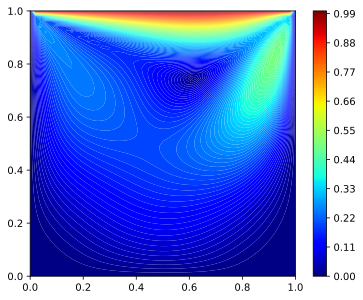

In [16]:
fig = plt.figure(dpi=600)
ax = fig.add_subplot(1,1,1)
ax.set_aspect(aspect=1.0)
CS = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],Vel_mag[1:ny+2,1:nx+2],levels=101,cmap='jet')
plt.colorbar(CS);

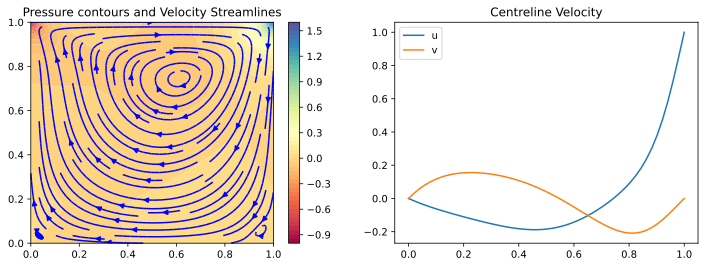

In [17]:
fig = plt.figure(figsize=[12,4],dpi=600)
ax = plt.subplot(1,2,1)
pcont = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],p_nodal[1:ny+2,1:nx+2],levels=51,cmap=plt.cm.Spectral)
plt.colorbar(pcont)

plt.streamplot(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],u_nodal[1:ny+2,1:nx+2],v_nodal[1:ny+2,1:nx+2],color='blue')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Pressure contours and Velocity Streamlines')

plt.subplot(1,2,2)
plt.plot(y[:,int(nx/2)],u_nodal[:,int(nx/2)])
plt.plot(x[int(ny/2),:],v_nodal[int(ny/2),:])
plt.legend(['u','v'])
plt.title('Centreline Velocity');